# Combine Grad-CAM with SmoothGrad for the visualization

In [ ]:
# Uninstall current versions
!pip uninstall -y tensorflow keras

# Install specific versions
!pip install tensorflow==2.15.0 keras==2.15.0

# Restart runtime
import os
os.kill(os.getpid(), 9)

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled 

Mounted at /content/drive
Found 1686 images belonging to 4 classes.


<ipython-input-1-dedd16ce0b2a>:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


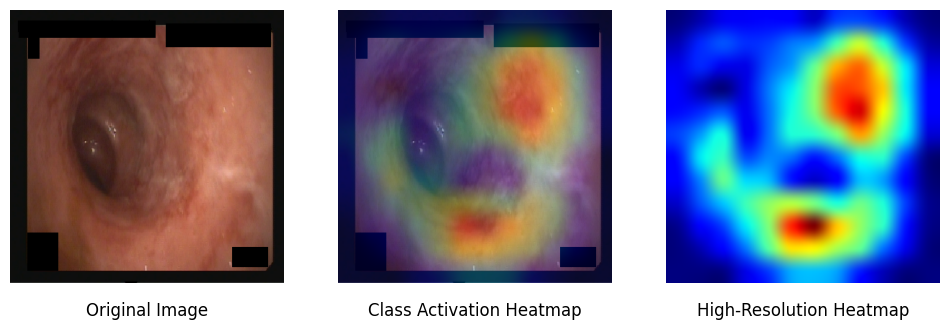

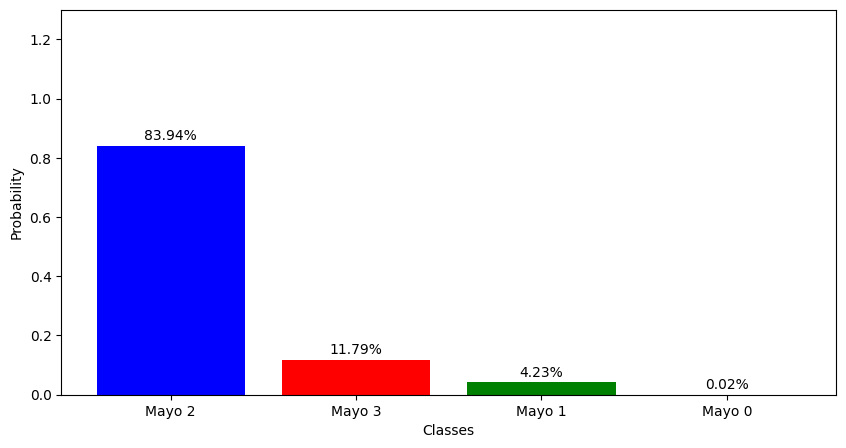

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Define the Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, ratio=16):
        super(SqueezeExcitationLayer, self).__init__()
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(output_dim // ratio, activation='swish')
        self.dense2 = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        self.reshape = tf.keras.layers.Reshape((1, 1, output_dim))
        self.multiply = tf.keras.layers.Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

# Define the Spatial Attention Layer
class SpatialAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

# Custom loss function wrapper (assuming it's already defined)
def custom_loss(num_classes):
    def loss(y_true, y_pred):
        return tf.keras.backend.categorical_crossentropy(y_true, y_pred)
    return loss

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Paths to the datasets
test_path = '/content/drive/My Drive/LIMUC/test_set'

# Initialize generators to get the number of classes
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(380, 380),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(test_generator.class_indices.keys())

# Load the best model using custom objects scope without compilation
with tf.keras.utils.custom_object_scope({'SqueezeExcitationLayer': SqueezeExcitationLayer, 'SpatialAttentionLayer': SpatialAttentionLayer, 'loss': custom_loss(len(class_labels))}):
    model = load_model('/content/drive/My Drive/LIMUC/Temp/RBSLF_best_model_fold_7.h5', compile=False)

# Compile the model manually if needed
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Function to find a suitable feature layer
def get_feature_layer(model):
    for layer in reversed(model.layers):
        if 'batch_normalization' in layer.name:
            return layer.name
    raise ValueError("No suitable layer found in the model.")

# Function to generate Grad-CAM
def generate_cam(model, img_array, class_idx):
    feature_layer_name = get_feature_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(feature_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Function to apply SmoothGrad
def apply_smoothgrad(generate_cam_fn, model, img_array, class_idx, num_samples=50, noise_level=0.1):
    smooth_heatmap = np.zeros_like(generate_cam_fn(model, img_array, class_idx))
    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level, img_array.shape)
        noisy_img_array = img_array + noise
        heatmap = generate_cam_fn(model, noisy_img_array, class_idx)
        smooth_heatmap += heatmap
    smooth_heatmap /= num_samples
    return smooth_heatmap

# Function to display CAM with high resolution
def display_cam(heatmap, img_array, alpha=0.4):
    img = tf.keras.preprocessing.image.array_to_img(img_array)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)

    # Resize heatmap to match the original image size
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]), resample=Image.BICUBIC)
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image', y=-0.15) # Original Image
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(superimposed_img)
    plt.title('Class Activation Heatmap', y=-0.15) # Class Activation Heatmap
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(jet_heatmap.astype(np.uint8))
    plt.title('High-Resolution Heatmap', y=-0.15) # High-Resolution Heatmap
    plt.axis('off')

    plt.show()

# Function to plot predictions
def plot_predictions(predictions, class_labels):
    top_4 = np.argsort(predictions)[::-1][:4]
    top_4_values = predictions[top_4]
    top_4_labels = [class_labels[i] for i in top_4]
    plt.figure(figsize=(10, 5))
    bars = plt.bar(top_4_labels, top_4_values, color=['blue', 'red', 'green', 'orange'])
    plt.ylabel('Probability')
    plt.xlabel('Classes')
    plt.ylim([0, 1.3])

    # Add percentage labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval*100:.2f}%', ha='center', va='bottom')

    plt.show()

# Define the predict function to avoid retracing
@tf.function
def predict(model, img_array):
    return model(img_array, training=False)

# Function to predict and visualize with SmoothGrad-GradCAM
def predict_and_visualize(model, img_path, class_labels, alpha=0.4, num_samples=50, noise_level=0.1):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(380, 380))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = predict(model, img_array)[0].numpy()
    class_idx = np.argmax(predictions)

    heatmap = apply_smoothgrad(generate_cam, model, img_array, class_idx, num_samples, noise_level)
    display_cam(heatmap, img_array[0], alpha=alpha)
    plot_predictions(predictions, class_labels)

# Test the function with a sample image
img_path = '/content/drive/My Drive/LIMUC/test_set/Mayo 2/UC_patient_45_8.bmp'   # Replace with the actual image path
predict_and_visualize(model, img_path, class_labels, alpha=0.4)
